# Signal classifier

A simple RNN to distinguish between four kinds of signals, namely, square, sin, gaussian, and sawtooth.
Singals are generated with a random frequencies within a range. 
When training on a CPU, I recommend reducing the range of the frequency to simplify the classification problem. 
The notebook is good to play around RNNs and see how they cope with variable length inputs.

In [1]:
#Import the necessary packets
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
# Generate different signal/waves with given frequencies and time period
class waveGenerator:
    def __init__(self, minTime = 1, maxTime=5, minFreq=2, maxFreq=10, samplingFreq = 500):
        self.minTime = minTime
        self.maxTime = maxTime
        self.minFreq = minFreq
        self.maxFreq = maxFreq
        self.samplingFreq = samplingFreq
        
    def square(self, freq, t):
        sig = signal.square(2 * np.pi * freq * t)
        return sig
    
    def sinwave(self, freq, t):
        sig = np.sin(2 * np.pi * freq* t)
        return sig
    
    def gaussian(self, freq, time):
        t = np.linspace(-time/2, time/2, self.samplingFreq, endpoint=False)
        sig, en = signal.gausspulse(t, fc=freq, retenv=True)
        return en
    
    def sawtooth(self, freq, t, randomizeTeeth= False):
        width= 1 
        if randomizeTeeth:
            width = np.random.rand(1)[0]
        sig =  signal.sawtooth(2 * np.pi * freq * t, width)
        return sig
    
    def freqCatergory(self, freq):
        #Low frequency
        if freq <= self.minFreq + (self.maxFreq - self.minFreq)/3:
            return [1,0,0,0]
        #Medium frequency
        elif freq  <= self.minFreq + 2* (self.maxFreq - self.minFreq)/3:
            return [0,1,0, 0]
        #High frequency
        else:
            return [0,0,1, 0]
    
    def randomWave(self):
        freq = np.random.randint(self.minFreq, self.maxFreq)   
#         time = np.random.randint(self.minTime, self.maxTime)
        t = np.linspace(0, time, self.samplingFreq, endpoint=False)
        w = np.random.randint(0, 4)
#         print(w)
#         w=3
        if w == 0:
            sig = self.sinwave(freq, t)
            out = [1,0,0,0] + self.freqCatergory(freq)
        elif w == 1:
            sig = self.square(freq, t)
            out = [0,1,0,0] + self.freqCatergory(freq)
        elif w == 2:
            sig = self.sawtooth(freq, t)
            out = [0,0,1,0] + self.freqCatergory(freq)
        else:
            sig = self.gaussian(freq, time)
            out = [0,0,0,1] + self.freqCatergory(freq)
        
        return sig, np.array(out[:4]), t
            
            

[0 0 1 0]
(500,)
(500,)


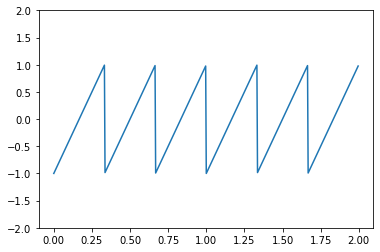

In [3]:
# Display a signal
freq, time = 30, 2
wave = waveGenerator()
sig, out, t = wave.randomWave()
plt.plot(t, sig)
plt.ylim(-2, 2)
print(out)
print(sig.shape)
print(t.shape)

In [4]:
#A plain LSTM model with dense layer at the end for classification
model = Sequential()

# Recurrent layer
model.add(
    LSTM(
        64, return_sequences=False, dropout=0.1,
        recurrent_dropout=0.1, input_shape=(None, 1)))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 21,316
Trainable params: 21,316
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Generate training samples
freq, time =30, 2
wave = waveGenerator()
X_train, y_train = [], []
for  i in range(10000):
    sig, out, t = wave.randomWave()
    X_train.append(sig.reshape(500,1))
    y_train.append(out)

X_train, y_train  = np.array(X_train), np.array(y_train) 
X_train.shape

(10000, 500, 1)

In [6]:
# Generate validation samples
freq, time =30, 2
wave = waveGenerator()
X_valid, y_valid = [], []
for  i in range(1000):
    sig, out, t = wave.randomWave()
    X_valid.append(sig.reshape(500,1))
    y_valid.append(out)

X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_valid.shape

(1000, 500, 1)

In [7]:
#Train the model
h = model.fit(X_train, y_train, epochs = 10, batch_size = 2048, 
          validation_data = (X_valid, y_valid), 
          verbose = 1)

Instructions for updating:
Use tf.cast instead.
Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 184us/step - loss: 1.3335 - accuracy: 0.3455 - val_loss: 1.2613 - val_accuracy: 0.7580
Epoch 2/10
10000/10000 [==============================] - 1s 132us/step - loss: 1.2300 - accuracy: 0.5848 - val_loss: 1.1312 - val_accuracy: 0.7580
Epoch 3/10
10000/10000 [==============================] - 1s 132us/step - loss: 1.0999 - accuracy: 0.6547 - val_loss: 0.9602 - val_accuracy: 0.7300
Epoch 4/10
10000/10000 [==============================] - 1s 130us/step - loss: 0.9854 - accuracy: 0.6134 - val_loss: 0.8577 - val_accuracy: 0.6250
Epoch 5/10
10000/10000 [==============================] - 1s 131us/step - loss: 0.9092 - accuracy: 0.5797 - val_loss: 0.7835 - val_accuracy: 0.5970
Epoch 6/10
10000/10000 [==============================] - 1s 133us/step - loss: 0.8377 - accuracy: 0.6494 - val_loss: 0.6957 - val_accuracy: 0.8450
Epoch 7/10
1000

In [11]:
# Generate validation samples
freq, time =30, 2
wave = waveGenerator()
X_test, y_test = [], []
for  i in range(1000):
    sig, out, t = wave.randomWave()
    X_test.append(sig.reshape(500,1))
    y_test.append(out)

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape

(1000, 500, 1)

In [12]:
# See when the model goes wrong
for i in range(100):
    x = X_test[i]
    preds = model.predict(x.reshape(1,500,1))
    if np.argmax(preds) != np.argmax(y_test[i]):
        print(np.argmax(preds), np.argmax(y_test[i]))
        print(preds, y_test[i])

1 0
[[0.4795053  0.48583907 0.00898362 0.02567206]] [1 0 0 0]
1 0
[[0.4795053  0.48583907 0.00898362 0.02567206]] [1 0 0 0]
1 0
[[0.4795053  0.48583907 0.00898362 0.02567206]] [1 0 0 0]
1 0
[[0.4795053  0.48583907 0.00898362 0.02567206]] [1 0 0 0]
1 0
[[0.4795053  0.48583907 0.00898362 0.02567206]] [1 0 0 0]
1 0
[[0.4795053  0.48583907 0.00898362 0.02567206]] [1 0 0 0]
1 0
[[0.4795053  0.48583907 0.00898362 0.02567206]] [1 0 0 0]


In [16]:
# What happens if we only pass in part of the signal
for i in range(100):
    x = X_test[i][:200]
    preds = model.predict(x.reshape(1,200,1))
    if np.argmax(preds) != np.argmax(y_test[i]):
        print(np.argmax(preds), np.argmax(y_test[i]))
        print(preds, y_test[i])

0 2
[[0.6966052  0.20440488 0.03448437 0.06450551]] [0 0 1 0]
2 1
[[0.04231546 0.00862679 0.9052384  0.04381933]] [0 1 0 0]
1 0
[[0.29874048 0.66215146 0.00939651 0.02971159]] [1 0 0 0]
2 3
[[0.16269736 0.12237027 0.3798813  0.3350511 ]] [0 0 0 1]
2 0
[[0.02124372 0.00584466 0.9473393  0.02557231]] [1 0 0 0]
2 3
[[0.16269736 0.12237027 0.3798813  0.3350511 ]] [0 0 0 1]
2 3
[[0.02315899 0.01226798 0.91868645 0.04588651]] [0 0 0 1]
2 0
[[0.00785645 0.00374986 0.9765105  0.01188312]] [1 0 0 0]
2 1
[[0.01854795 0.01186624 0.93866575 0.03092002]] [0 1 0 0]
1 0
[[0.29874048 0.66215146 0.00939651 0.02971159]] [1 0 0 0]
2 1
[[0.01854795 0.01186624 0.93866575 0.03092002]] [0 1 0 0]
2 1
[[0.01854795 0.01186624 0.93866575 0.03092002]] [0 1 0 0]
0 2
[[0.6574029  0.17572117 0.05891672 0.10795918]] [0 0 1 0]
1 2
[[0.45097908 0.5146172  0.0086425  0.02576116]] [0 0 1 0]
2 1
[[0.04231546 0.00862679 0.9052384  0.04381933]] [0 1 0 0]
2 1
[[0.04231546 0.00862679 0.9052384  0.04381933]] [0 1 0 0]
2 3
[[0.